# 0. Imports

In [1]:
# Imports
from   IPython.display import display, HTML
import numpy as np
import pandas as pd
from pprint import pprint
import matplotlib.pyplot as plt
import logging
logging.basicConfig()
logging.getLogger('apscheduler').setLevel(logging.CRITICAL)

# Display options
pd.set_option('display.width', 1000)
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('mode.chained_assignment', None)

In [2]:
import mimicLOB as lob
from mimicLOB.orderbook.orderbook import OrderBook
from mimicLOB.agent.genericAgent import genericAgent
from mimicLOB.utils import getInstance
from mimicLOB.information.channel import Channel
from mimicLOB.utils import getBookHistory

# 1. LOB Creation

In [3]:
# b_tape = True means the LOB 
LOB = OrderBook(tick_size = 0.1, 
                b_tape    = True,
                verbose   = False)

## Simulation configuration

#### Random Agent : a random agent is either a liquidity provider via limit order or a liquidity consumer via market orders. The agent has an intensity of sending order. 
#### Random agents react to exogenous news, their intensity of sending orders is shifted according to news arrival. 
#### News object is a random process between 0 & 100, 0 being the worst news and 100 very good news. For examples, buyers will buy more if the news are very good. This enables trends in prices.

#### Parameters :
1. distant : if true, the agent must have the server address. If False, he should have the orderbook object passed in the configuration.
2. server : when distant is True, the http address of the server the LOB is running on.
3. id : optional, default is generic. the if is used in the transaction tape.
4. b_record : optional, boolean, default is False. If True, the agent records all his activity : sent orders, executed trades, pending orders ...

In [4]:
Simulationconfig = {'information' : {'basicInfo' : {'type'        : 'genericInformation',
                                                    'intensity'   : 0.03}},
                    'agents'      : {'agent1' : {'type'         : 'randomAgent',
                                                'subtype'       : 'randomLimitBuyer',
                                                 'id'           : 'agent1',
                                                'orderbook'     : LOB,
                                                'intensity'     : 0.4,
                                                'quantityRange' : [50, 200, 10]},
                                    'agent2' : {'type'          : 'randomAgent',
                                                'subtype'       : 'randomMarketBuyer',
                                                 'id'           : 'agent2',
                                                'orderbook'     : LOB,
                                                'intensity'     : 0.4,
                                                'quantityRange' : [50, 200, 10]},
                                    'agent3' : {'type'          : 'randomAgent',
                                                'subtype'       : 'randomLimitSeller',
                                                 'id'           : 'agent3',
                                                'orderbook'     : LOB,
                                                'intensity'     : 0.4,
                                                'quantityRange' : [50, 200, 10]},
                                    'agent4' : {'type'          : 'randomAgent',
                                                'subtype'       : 'randomMarketSeller',
                                                 'id'           : 'agent4',
                                                'orderbook'     : LOB,
                                                'intensity'     : 0.4,
                                                'quantityRange' : [50, 200, 10]},
                                    'MM'     : {'type'          : 'basicMM',
                                                 'id'           : 'MM',
                                                'orderbook'     : LOB,
                                                'refQuantity'   : 100,
                                                'refPrice'      : 100,
                                                'b_record'      : True}}}

## Create News Information

In [5]:
# Channel (doubly linked chain of news)
newsChannel = Channel()

# keeps references on information sources
newsFactory = {}
config_news = Simulationconfig['information']
for info in config_news:
    config_news[info]['channel'] = newsChannel
    newsFactory[info] = getInstance('mimicLOB.information', config_news[info])

## Create the agents
The agents is constantly connected to the distant LOB via the server address or the LOB address.

In [6]:
agentFactory  = {} # keeps references on agents
config_agents = Simulationconfig['agents']

for agent in config_agents:
    config_agents[agent]['channel'] = newsChannel
    agentFactory[agent] = getInstance('mimicLOB.agent', config_agents[agent])   
    
# The market (LOB admin)
market = genericAgent(id = 'market', orderbook = LOB)

## Launch Trading

#### We launch trading

#### You have to execute the stop or pause command to stop simulation (wait a few seconds of trading at least)

In [7]:
from apscheduler.schedulers.background import BackgroundScheduler

sched = BackgroundScheduler()

def startSimulation():
    for agent in agentFactory:
        agentFactory[agent].start(sched)
        
    for news in newsFactory:
        newsFactory[news].start(sched)

In [8]:
sched.start()
startSimulation()

## Pause Trading
#### INFO : trading still continues, even if the previous cell is not 'running'. The aps scheduler executes tasks in the background !

In [26]:
try:
    sched.pause()
except Exception as e:
    print(e)

## Resume Trading

In [11]:
try:
    sched.resume()
except Exception as e:
    print(e)

## Stop Trading

In [30]:
try:
    sched.shutdown()
except Exception as e:
    print(e)

In [30]:
# uncomment to reset lob : 
# market.resetLOB_PendingOrders()

## Get LOB

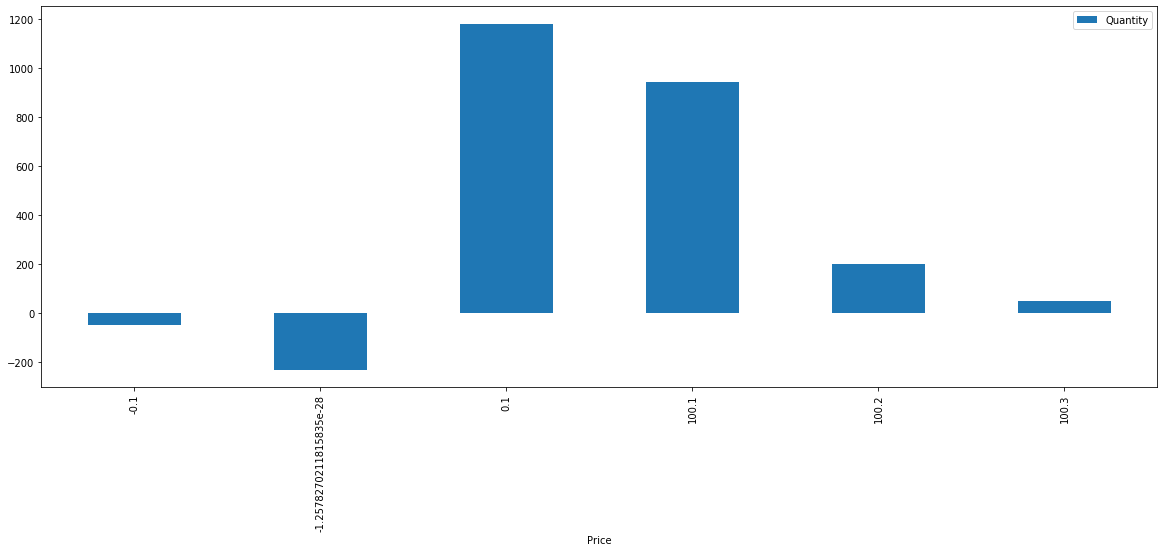

In [13]:
LOBstate = market.getLOBState()
LOBstate = LOBstate.set_index('Price').sort_index()
LOBstate.plot.bar(figsize=(20, 7))
plt.show()

## Get Price Tape

'open  : 100.0'

'high  : 100.4'

'low   : 0.0'

'close : 99.60000000000001'

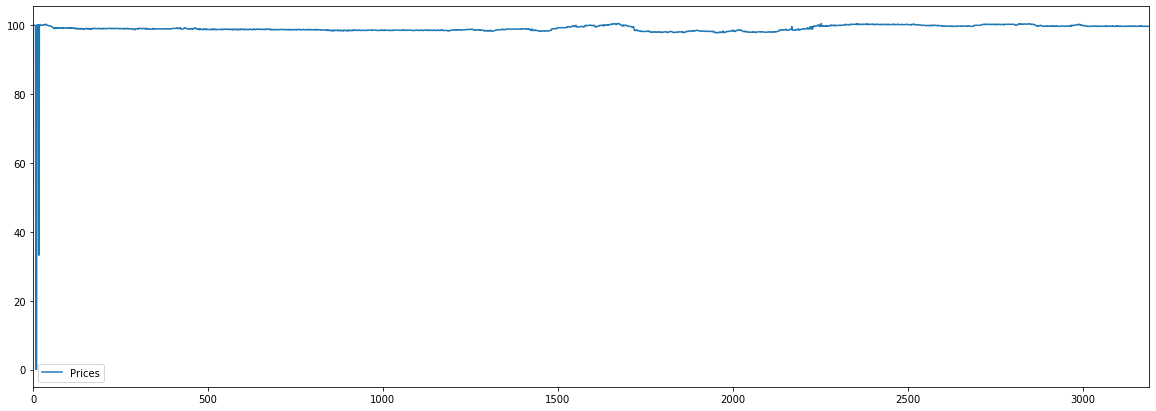

In [34]:
histoPrices = market.getPriceTape().astype(float)
histoPrices.plot(figsize=(20,7))

# OHLC
display(f'open  : {histoPrices.iloc[0,0]}')
display(f'high  : {histoPrices.max()[0]}')
display(f'low   : {histoPrices.min()[0]}')
display(f'close : {histoPrices.iloc[-1, 0]}')

plt.show()

## Get Transaction Tape

In [36]:
TransactionTape = market.getTransactionTape()

In [37]:
TransactionTape

,time,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id,traded_price,traded_quantity
0,1587228969712419500,MM,ask,7,agent2,ask,None,99.99999999999999999999999998,100
1,1587228969712419500,MM,ask,3,agent2,ask,None,100.1000000000000000055511151,90
2,1587228969914900800,agent3,ask,8,agent2,ask,None,100.0000000000000000000000000,150
3,1587228970057342100,MM,bid,1,agent4,bid,None,99.89999999999999999444888488,100
4,1587228970057342100,agent1,bid,10,agent4,bid,None,99.89999999999999999444888488,30
...,...,...,...,...,...,...,...,...,...
3186,1587229109864179000,agent1,bid,2935,agent4,bid,None,99.60000000000000552891066263,35
3187,1587229110020703400,agent1,bid,2935,agent4,bid,None,99.60000000000000552891066263,63
3188,1587229110020703400,agent1,bid,2937,agent4,bid,None,99.60000000000000552891066263,32
3189,1587229110020703400,agent1,bid,2938,agent4,bid,None,99.60000000000000552891066263,98


## Get the MM book history

In [23]:
executedTrades = pd.DataFrame.from_dict(agentFactory['MM'].executedtrades).T
executedTrades.set_index('time')

,traded_price,traded_quantity,party1_id,party1_side,party1_order_id,party2_id,party2_side,party2_order_id
time,,,,,,,,
1587228969712419500,99.99999999999999999999999998,100,MM,ask,7,agent2,ask,None
1587228969712419500,100.1000000000000000055511151,90,MM,ask,3,agent2,ask,None
1587228970057342100,99.89999999999999999444888488,100,MM,bid,1,agent4,ask,None
1587228970224641300,99.79999999999999998889776975,50,MM,bid,2,agent4,ask,None
1587228970224641300,0,47,MM,bid,5,agent4,ask,None
...,...,...,...,...,...,...,...,...
1587229069142582300,100.1000000000000055566662382,13,MM,ask,2465,agent2,ask,None
1587229069142582300,100.2000000000000055622173533,50,MM,ask,2466,agent2,ask,None
1587229069177071100,100.0000000000000055511151231,28,MM,bid,2464,agent4,ask,None


In [24]:
# Book evolution :
book = getBookHistory(executedTrades, 'MM')

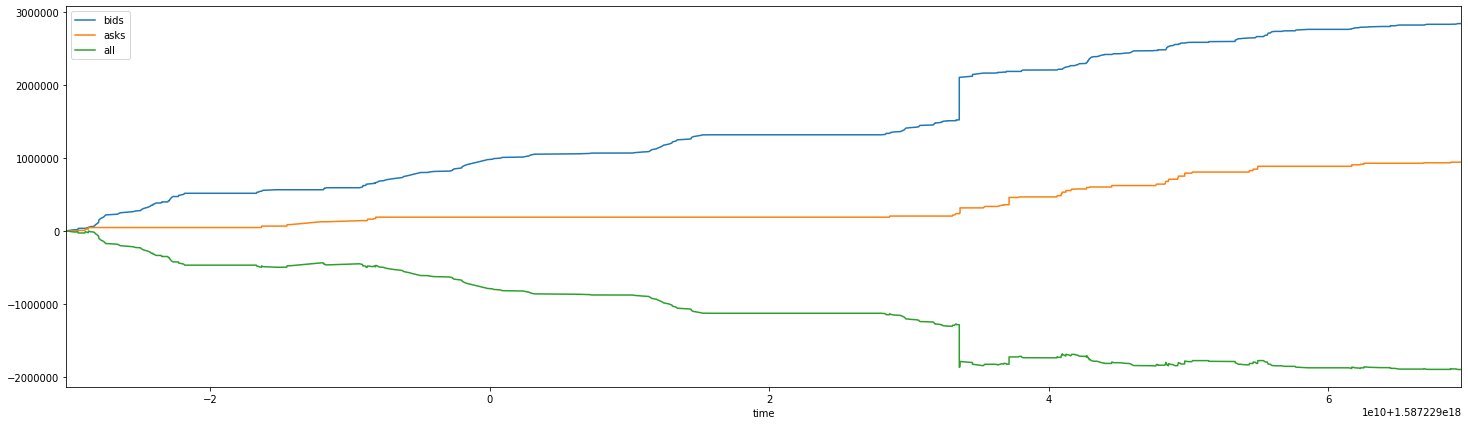

In [25]:
book.astype(float).plot(figsize=(25,7))